### Necessary imports

In [1]:
import os
import random

In [2]:
from pathlib import Path

import pandas as pd
from tqdm import tqdm
from PIL import Image

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchsummary import summary

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
# For Google Collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# For Google Collab
!mkdir samples
# unzip archive "captcha.zip" with data (lying in root folder)
!unzip -q drive/MyDrive/captcha.zip -d captcha/

mkdir: cannot create directory ‘samples’: File exists
replace captcha/p5g5m.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [8]:
# For Google Collab
data_path = Path('./captcha')

In [9]:
# Not for Google Collab
# data_path = Path('../data/captcha')

## Data preparation

In [10]:
pics_names = os.listdir(data_path)  # list of imeges filenames: ['p5g5m.png', ...]
pics_pathes = [data_path / pic for pic in pics_names]
print(f"Number of samples: {len(pics_names)}")

Number of samples: 1070


Captcha: 6mege
Image:


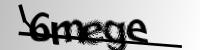

Size: (200, 50)


In [11]:
# show random image from dataset
rnd_filename = random.choice(pics_names)
rnd_im = Image.open(data_path / rnd_filename)

print(f"Captcha: {rnd_filename.split('.')[0]}")
print("Image:")
display(rnd_im)
print(f"Size: {rnd_im.size}")

In [12]:
# compose dataframe
data_df = pd.DataFrame(
    {
        'file': pics_pathes, 
        'pic_size': [Image.open(pic).size for pic in pics_pathes],
        'pic_mode': [Image.open(pic).mode for pic in pics_pathes],
        'label': [name.split(".")[0] for name in pics_names], 
    }
)
data_df.head()

,file,pic_size,pic_mode,label
0,captcha/e2mg2.png,"(200, 50)",RGBA,e2mg2
1,captcha/xwx7d.png,"(200, 50)",RGBA,xwx7d
2,captcha/3ndxd.png,"(200, 50)",RGBA,3ndxd
3,captcha/gn2d3.png,"(200, 50)",RGBA,gn2d3
4,captcha/6end3.png,"(200, 50)",RGBA,6end3


### Statistics

In [13]:
data_df["pic_size"].value_counts()

(200, 50)    1070
Name: pic_size, dtype: int64

In [14]:
data_df["pic_mode"].value_counts()

RGBA    1040
RGB       30
Name: pic_mode, dtype: int64

In [15]:
set(len(cap) for cap in data_df["label"])  # captchas lengths

{5}

- All pictures are of the same size: $(200,50)$
- All captchas are of the same length: $5$

In [16]:
CAPTCHA_WIDTH, CAPTCHA_HEIGHT = (200, 50)

### Tokenization

In [17]:
tokens_set = sorted(set("".join(data_df["label"])))  # all symbols used in captchas from dataset
N_TOKENS = len(tokens_set)

print(f"There are {N_TOKENS} characters used in dataset")
print(f"All tokens: {tokens_set}")

There are 19 characters used in dataset
All tokens: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [18]:
# tokens dictionaries
token_to_idx = {token: ind for ind, token in enumerate(tokens_set)}
# add an "blank" token
BLANK_TOKEN = "."
BLANK_IND = len(token_to_idx)
token_to_idx[BLANK_TOKEN] = BLANK_IND

idx_to_token = {ind: token for token, ind in token_to_idx.items()}

In [19]:
for token, ind in token_to_idx.items():
    assert idx_to_token[ind] == token

print("Index\t\tToken")
for item in idx_to_token.items():
    print(f"{item[0]}\t-\t{item[1]}")

Index		Token
0	-	2
1	-	3
2	-	4
3	-	5
4	-	6
5	-	7
6	-	8
7	-	b
8	-	c
9	-	d
10	-	e
11	-	f
12	-	g
13	-	m
14	-	n
15	-	p
16	-	w
17	-	x
18	-	y
19	-	.


In [20]:
N_TOKENS = len(token_to_idx)

## Compose dataset

In [22]:
class CaptchaDS(Dataset):
    def __init__(self, data_df, transform, target_transform=None):
        self.files = data_df.file
        self.labels = data_df.label
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ind):
        # some images have RGBA mode
        image = Image.open(self.files[ind]).convert('L')  # .convert('RGB')
        label = self.labels[ind] 
        if self.target_transform:  # transform label
            label = self.target_transform(label)
        return self.transform(image), label

In [23]:
def label_transformer(captcha):
    # Output: list (tensor) of token's indices: list[int*len(captcha)]
    return torch.tensor([token_to_idx[token] for token in captcha],
                        dtype=torch.long)

In [24]:
def label_detransformer(captcha):
    # Input: list (tensor) of token's indices: list[int*len(captcha)]
    # Output: string
    return "".join([idx_to_token[int(ind)] for ind in captcha])

In [25]:
label_transformer("68wfd")  # example of lable_transformer work

tensor([ 4,  6, 16, 11,  9])

In [26]:
label_detransformer(label_transformer("68wfd"))

'68wfd'

In [27]:
# CAPTCHA_WIDTH, CAPTCHA_HEIGHT = (300, 75)  # trying to resize images

# captcha_dataset = CaptchaDS(
#     data_df, 
#     transform=transforms.Compose([transforms.Resize((CAPTCHA_HEIGHT,
#                                                      CAPTCHA_WIDTH)),
#                                   transforms.ToTensor()]),
#     target_transform=label_transformer
# )  # resize pipeline

In [28]:
# Dataset
captcha_dataset = CaptchaDS(
    data_df, 
    transform=transforms.ToTensor(),
    target_transform=label_transformer  # tokens to indices
)  # simple pipeline

Divide into `training` and `test` samples in a ratio of $4:1$

In [29]:
BATCH_SIZE = 32

In [30]:
train_size = int(4 / 5 * len(captcha_dataset))
test_size = len(captcha_dataset) - train_size

# train/test split
train_dataset, test_dataset = random_split(captcha_dataset,
                                           [train_size, test_size]
                                           )
print(f"Train size: {len(train_dataset)}\nTest size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True
                          )
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False
                         )

print(f"Train loader: {len(train_loader)}\nTest loader: {len(test_loader)}")

Train size: 856
Test size: 214
Train loader: 26
Test loader: 7


In [31]:
# batch shape
next(iter(train_loader))[0].shape

torch.Size([32, 1, 50, 200])

## Model building

**Convolutional Recurrent Neural Network (CRNN)**

`LeNet-5` based convolution model:

- 5x5 filters are replaced with 2 consecutive 3x3 filters

- `max-pooling` is replaced with strided convolutions

The resulted higher level features are fed into a 2 layer `GRU RNN` with a linear layer in the end which has **20** possible outputs (captcha characters 19 + blank character 1). `GRU` is chosen over `LSTM` since it had similar results but required fewer resources.

In [32]:
# device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


In [33]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        #self.in1 = nn.InstanceNorm2d(32, affine=True)
        #self.in1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3))
        #self.in2 = nn.InstanceNorm2d(32, affine=True)
        #self.in2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2)
        #self.in3 = nn.InstanceNorm2d(32, affine=True)
        #self.in3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3))
        #self.in4 = nn.InstanceNorm2d(64, affine=True)
        #self.in4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3,3))
        #self.in5 = nn.InstanceNorm2d(64, affine=True)
        #self.in5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        #self.in6 = nn.InstanceNorm2d(64, affine=True)
        #self.in6 = nn.BatchNorm2d(64)

        self.postconv_height = 8
        self.postconv_width = 46
        self.gru_input_size = self.postconv_height * 64
        self.gru_hidden_size = 128 
        self.gru_num_layers = 2
        self.gru_h = None

        self.gru = nn.GRU(
            self.gru_input_size, self.gru_hidden_size, 
            self.gru_num_layers, batch_first=True, bidirectional=True
        )

        self.fc = nn.Linear(self.gru_hidden_size * 2, self.num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        #print(" == conv1 input:", x.shape)  # torch.Size([bs, 1, 50, 200])
        out = self.conv1(x)
        out = F.leaky_relu(out)
        ##out = self.in1(out)
        #print(" == conv2 input:", out.shape)  # torch.Size([bs, 32, 48, 198])
        out = self.conv2(out) 
        out = F.leaky_relu(out)
        ##out = self.in2(out)
        #print(" == conv3 input:", out.shape)  # torch.Size([bs, 32, 46, 196])
        out = self.conv3(out)
        out = F.leaky_relu(out)
        ##out = self.in3(out)
        #print(" == conv4 input:", out.shape)  # torch.Size([bs, 32, 22, 97])
        out = self.conv4(out)
        out = F.leaky_relu(out)
        ##out = self.in4(out)
        #print(" == conv5 input:", out.shape)  # torch.Size([bs, 64, 20, 95])
        out = self.conv5(out)
        out = F.leaky_relu(out)
        ##out = self.in5(out)
        #print(" == conv6 input:", out.shape)  # torch.Size([bs, 64, 18, 93])
        out = self.conv6(out)
        out = F.leaky_relu(out)
        ##out = self.in6(out)
        #print(" == conv6 output:", out.shape)  # torch.Size([bs, 64, 8, 46]) <- postconv height/width

        out = out.permute(0, 3, 2, 1) 
        #print("  -- permute:", out.shape)  # torch.Size([bs, 46, 8, 64])
        out = out.reshape(batch_size, -1, self.gru_input_size)
        #print("  -- reshape (gru input):", out.shape)  # torch.Size([bs, 46, 512])

        out, gru_h = self.gru(out, self.gru_h)
        #print(" == gru output:", out.shape, gru_h.shape)  # torch.Size([bs, 46, 256]) torch.Size([4, bs, 128])
        self.gru_h = gru_h.detach()
        
        # out[i].shape = torch.Size([46, 256]), fc(out[i]).shape = torch.Size([46, 20]) <- [46x256]*[256x20]=[46x20]
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        #print(" == stack output:", out.shape)  # torch.Size([bs, 46, 20])
        
        return out

    def reset_hidden(self, batch_size):
        self.gru_h = torch.zeros(self.gru_num_layers * 2, batch_size, self.gru_hidden_size).to(device)

In [34]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import torchinfo

In [36]:
model = CRNN(num_classes=N_TOKENS)
torchinfo.summary(model, (1, 1, CAPTCHA_HEIGHT, CAPTCHA_WIDTH), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [1, 46, 20]               --
├─Conv2d: 1-1                            [1, 32, 48, 198]          320
├─Conv2d: 1-2                            [1, 32, 46, 196]          9,248
├─Conv2d: 1-3                            [1, 32, 22, 97]           9,248
├─Conv2d: 1-4                            [1, 64, 20, 95]           18,496
├─Conv2d: 1-5                            [1, 64, 18, 93]           36,928
├─Conv2d: 1-6                            [1, 64, 8, 46]            36,928
├─GRU: 1-7                               [1, 46, 256]              789,504
├─Linear: 1-8                            [46, 20]                  5,140
Total params: 905,812
Trainable params: 905,812
Non-trainable params: 0
Total mult-adds (M): 253.26
Input size (MB): 0.04
Forward/backward pass size (MB): 7.41
Params size (MB): 3.62
Estimated Total Size (MB): 11.07

A `log_softmax` activation function is used in the final layer since it the loss function (PyTorch's `CTCLoss`) requires a logarithmized version of the output; also, this should provide better numerical properties as it highly penalizes incorrect classifications.

In [37]:
# weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find("Norm") != -1:
        m.weight.data.normal_(1.0, 0.02) # InstanceNorm2d -> affine=True
        m.bias.data.fill_(0)

## Training and evaluating loops

CRNN is trained with Connectionist Temporal Classification (CTC) loss.

Calculates loss between a continuous (unsegmented) time series and a target sequence. `CTCLoss` sums over the probability of possible alignments of input to target, producing a loss value which is differentiable with respect to each input node. The alignment of input to target is assumed to be "many-to-one", which limits the length of the target sequence such that it must be $\leq$ the input length.

[`torch.nn.CTCLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html)

In [38]:
from itertools import groupby

In [39]:
def model_train_eval(model, mode, data_loader):
    if mode == "train":
        model.train()
    elif mode == "eval":
        model.eval()

    correct, total = 0, 0
    total_loss, num_batches = 0, 0

    for x_sample, y_sample in tqdm(data_loader):
        batch_size = x_sample.shape[0]
        # reset the hidden state of the GRU layers before recognizing any new sequence
        crnn.reset_hidden(batch_size)

        if mode == "train":
            optimizer.zero_grad()  
    
        y_pred = crnn(x_sample.to(device))
        # reorder the CRNN's output so it matches the CTCLoss's desired input format
        y_pred = y_pred.permute(1, 0, 2)

        input_lengths = torch.IntTensor(batch_size).fill_(crnn.postconv_width)
        target_lengths = torch.IntTensor([len(t) for t in y_sample])

        loss = criterion(y_pred, y_sample.to(device), input_lengths, target_lengths)
        # criterion(log_probs, targets, input_lengths, target_lengths)
        total_loss += loss.item()

        if mode == "train":
            loss.backward()
            optimizer.step()

        _, max_index = torch.max(y_pred.detach().cpu(), dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].numpy())
            # groupby -> remove duplicates
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != BLANK_TOKEN])
            if len(prediction) == len(y_sample[i]) and torch.all(prediction.eq(y_sample[i])):
                correct += 1
        
        total += batch_size
        num_batches += 1

    print(f"{mode} correct: {correct} / {total} = {correct / total:.4f}")
    return total_loss / num_batches

## Training

In [40]:
LR = 0.001
N_EPOCHS = 30  # 20 - 30

In [41]:
# model initialization
crnn = CRNN(num_classes=N_TOKENS)
crnn.apply(weights_init)
crnn.to(device)

criterion = nn.CTCLoss(blank=BLANK_IND, reduction="mean", zero_infinity=True)
optimizer = torch.optim.Adam(crnn.parameters(), lr=LR)

In [42]:
# train/eval model
history = []
for epoch in range(1, N_EPOCHS + 1):
    print(f"\nEPOCH #{epoch}")
    train_loss = model_train_eval(crnn, mode="train", data_loader=train_loader)
    test_loss = model_train_eval(crnn, mode="eval", data_loader=test_loader)
    print(f"Train loss: {train_loss:.4f}\nTest loss: {test_loss:.4f}")
    history.append((train_loss, test_loss))


EPOCH #1


100%|██████████| 26/26 [00:03<00:00,  8.13it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 15.56it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 5.3462
Test loss: 3.2968

EPOCH #2


100%|██████████| 26/26 [00:01<00:00, 18.85it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 36.59it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 3.2863
Test loss: 3.2532

EPOCH #3


100%|██████████| 26/26 [00:01<00:00, 14.48it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 18.59it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 3.2639
Test loss: 3.2587

EPOCH #4


100%|██████████| 26/26 [00:02<00:00, 12.91it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 21.32it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 3.2576
Test loss: 3.2563

EPOCH #5


100%|██████████| 26/26 [00:02<00:00, 12.63it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 20.77it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 3.2539
Test loss: 3.2360

EPOCH #6


100%|██████████| 26/26 [00:02<00:00, 11.58it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 3.1979
Test loss: 3.1262

EPOCH #7


100%|██████████| 26/26 [00:03<00:00,  6.64it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 17.86it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 2.9884
Test loss: 2.8160

EPOCH #8


100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 31.62it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 2.2037
Test loss: 1.4422

EPOCH #9


100%|██████████| 26/26 [00:01<00:00, 19.06it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 34.20it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.8959
Test loss: 0.4977

EPOCH #10


100%|██████████| 26/26 [00:01<00:00, 20.45it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 36.16it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.3542
Test loss: 0.3187

EPOCH #11


100%|██████████| 26/26 [00:01<00:00, 20.24it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 35.88it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.1929
Test loss: 0.1661

EPOCH #12


100%|██████████| 26/26 [00:01<00:00, 20.40it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 33.94it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.1156
Test loss: 0.1079

EPOCH #13


100%|██████████| 26/26 [00:01<00:00, 18.24it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 28.52it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0758
Test loss: 0.0901

EPOCH #14


100%|██████████| 26/26 [00:01<00:00, 16.58it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 27.08it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0483
Test loss: 0.0717

EPOCH #15


100%|██████████| 26/26 [00:01<00:00, 16.01it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 36.33it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0341
Test loss: 0.0467

EPOCH #16


100%|██████████| 26/26 [00:01<00:00, 20.22it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 34.39it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0249
Test loss: 0.0405

EPOCH #17


100%|██████████| 26/26 [00:01<00:00, 19.36it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 36.77it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0206
Test loss: 0.0398

EPOCH #18


100%|██████████| 26/26 [00:02<00:00, 12.67it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0163
Test loss: 0.0343

EPOCH #19


100%|██████████| 26/26 [00:02<00:00, 12.31it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 24.42it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0133
Test loss: 0.0360

EPOCH #20


100%|██████████| 26/26 [00:02<00:00,  9.51it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 11.78it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0107
Test loss: 0.0285

EPOCH #21


100%|██████████| 26/26 [00:03<00:00,  6.57it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 18.15it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0080
Test loss: 0.0279

EPOCH #22


100%|██████████| 26/26 [00:02<00:00, 12.30it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 17.06it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0063
Test loss: 0.0253

EPOCH #23


100%|██████████| 26/26 [00:01<00:00, 14.82it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 14.24it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0055
Test loss: 0.0241

EPOCH #24


100%|██████████| 26/26 [00:02<00:00, 11.99it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 35.60it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0048
Test loss: 0.0230

EPOCH #25


100%|██████████| 26/26 [00:01<00:00, 20.58it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 34.38it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0043
Test loss: 0.0227

EPOCH #26


100%|██████████| 26/26 [00:01<00:00, 16.67it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 27.92it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0039
Test loss: 0.0218

EPOCH #27


100%|██████████| 26/26 [00:01<00:00, 16.28it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 27.44it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0037
Test loss: 0.0213

EPOCH #28


100%|██████████| 26/26 [00:01<00:00, 18.45it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 34.68it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0033
Test loss: 0.0205

EPOCH #29


100%|██████████| 26/26 [00:01<00:00, 20.35it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 36.56it/s]


eval correct: 0 / 214 = 0.0000
Train loss: 0.0030
Test loss: 0.0207

EPOCH #30


100%|██████████| 26/26 [00:01<00:00, 20.33it/s]


train correct: 0 / 832 = 0.0000


100%|██████████| 7/7 [00:00<00:00, 34.81it/s]

eval correct: 0 / 214 = 0.0000
Train loss: 0.0028
Test loss: 0.0199


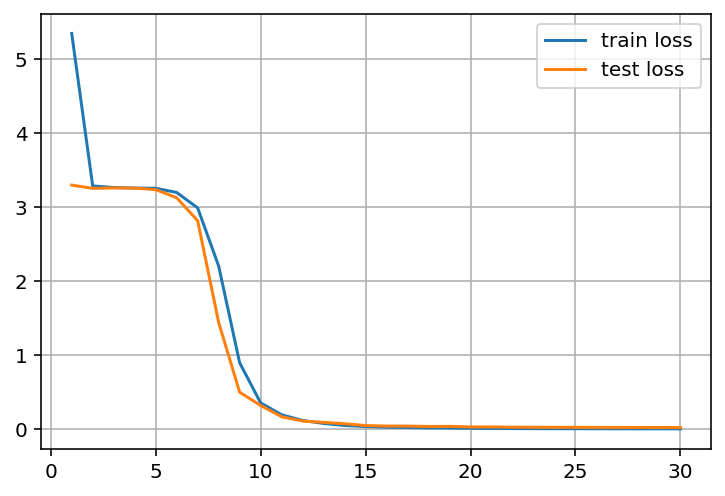

In [43]:
plt.plot(range(1, N_EPOCHS+1), [loss[0] for loss in history], label="train loss")
plt.plot(range(1, N_EPOCHS+1), [loss[1] for loss in history], label="test loss")
plt.grid()
plt.legend();

## Metrics calculations

Character Error Rate
([CER](https://towardsdatascience.com/evaluating-ocr-output-quality-with-character-error-rate-cer-and-word-error-rate-wer-853175297510))

CER calculation is based on the concept of Levenshtein distance, where we count the minimum number of character-level operations required to transform the ground truth text (aka reference text) into the OCR output.

$$\mathbf{CER} = \frac{S + D + I}{N}$$

$S$: Number of Substitutions

$N$: Number of Deletions

$I$: Number of Insertions

$N$: Number of characters in reference text (aka ground truth)

*The denominator $N$ can alternatively be computed with:
$N = S + D + C$ (where $C$ is number of correct characters)*

The output of this equation represents the percentage of characters in the reference text that was incorrectly predicted in the OCR output. The lower the CER value (with 0 being a perfect score), the better the performance of the OCR model.

[torchmetrics](https://torchmetrics.readthedocs.io/en/stable/text/char_error_rate.html)

In [44]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import torchmetrics

In [46]:
# character error rate
cer = torchmetrics.CharErrorRate()
cer(preds='80g475Z7', target='809475127')

tensor(0.3333)

In [49]:
preds_info = []

for x_test, y_test in tqdm(test_loader):
    crnn.eval()

    batch_size = x_test.shape[0]
    crnn.reset_hidden(batch_size)
    y_pred = crnn(x_test.to(device))  
    y_pred = y_pred.permute(1, 0, 2)
    
    _, max_index = torch.max(y_pred.detach().cpu(), dim=2)
    for i in range(batch_size):
        raw_prediction = list(max_index[:, i].numpy())
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != BLANK_IND])
        pred = "".join([idx_to_token[idx] for idx in prediction.numpy()])
        trgt = "".join([idx_to_token[idx] for idx in y_test[i].numpy()])
        preds_info.append((pred, trgt, cer(pred, trgt).item()))

100%|██████████| 7/7 [00:00<00:00, 12.07it/s]


In [50]:
preds_df = pd.DataFrame(
    {
        "prediction": [p[0] for p in preds_info], 
        "target": [p[1] for p in preds_info], 
        "cer": [p[2] for p in preds_info]
    }
)
preds_df.head()

,prediction,target,cer
0,px8n8,px8n8,0.0
1,pw5nc,pw5nc,0.0
2,w6yne,w6yne,0.0
3,mnef5,mnef5,0.0
4,d7nn3,d7nn3,0.0


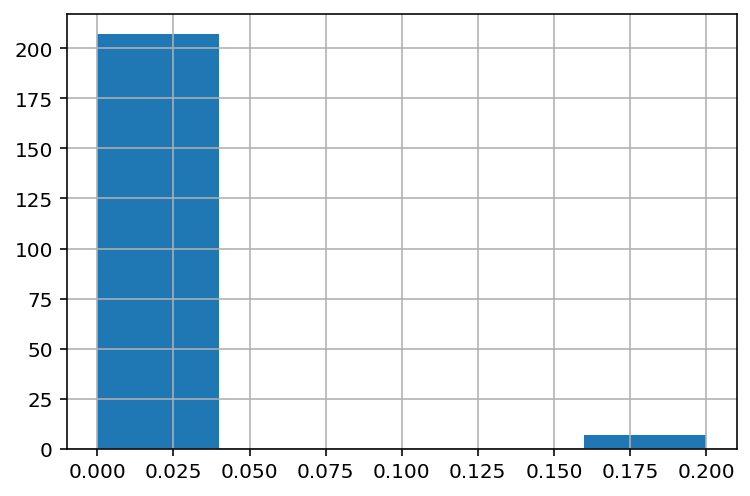

In [51]:
preds_df.cer.hist(bins=5);

In [52]:
preds_df.loc[preds_df.cer > 0.15]

,prediction,target,cer
12,gn4n4,en4n4,0.2
20,mp7wwp,mp7wp,0.2
32,gfe62,efe62,0.2
136,65nm,65nmw,0.2
152,ncwn7,ncww7,0.2
187,wwce5n,wce5n,0.2
190,p2d7,p2dw7,0.2


Captcha 1
Label: mp7wp
Pred: mp7wwp


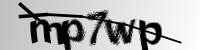


Captcha 2
Label: en4n4
Pred: gn4n4


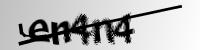


Captcha 3
Label: wce5n
Pred: wwce5n


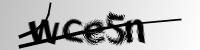


Captcha 4
Label: p2dw7
Pred: p2d7


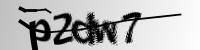


Captcha 5
Label: ncww7
Pred: ncwn7


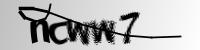


Captcha 6
Label: 65nmw
Pred: 65nm


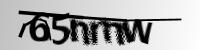


Captcha 7
Label: efe62
Pred: gfe62


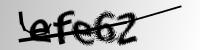

In [79]:
# bad recognition
bad_rec = data_df.loc[
    data_df.label.isin(preds_df.loc[preds_df.cer > 0.15, 'target']), 
    'file'
]  # obtain files

for ind_p, p in enumerate(bad_rec):
    true_label = p.name.split(".")[0]
    ind = list(preds_df.index[preds_df.target == true_label])[0]
    pred_label = preds_df.iloc[ind]["prediction"]
    print(f"Captcha {ind_p + 1}\nLabel: {true_label}\nPred: {pred_label}")
    im = Image.open(p)
    display(im)
    print()

### Possible causes of errors:

1. Some symbols are looks similar
- for `captcha 5` blured `w` looks like `n` (left bar of `w` is blured more than the rest of the letter)
- for `captcha 6` – `w` looks like `m` and the gap in between is small: nn groups them in one `m`-token instead of distincting two separate symbols

2. Predicting blank token at the middle (by time steps) of the letter
- `captchas 1` and `3`

3. Bad _noize lines_ location near the symbol 
- for `captchas 2` and `7` `e` looks like `g` because of it

4. For `captcha 4` I have not see obvious reasons for such _miss-recognition_.